# Month 4-6

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

In [2]:
df=pd.read_csv("C:\\Users\\madhu\\OneDrive\\Desktop\\Sports_analysis_capstone\\new_dataset.csv")

In [3]:
print(df.dtypes)

Played_Id                                 int64
Player                                   object
Team                                     object
Age                                       int64
Position                                 object
Assists                                   int64
YellowCards                               int64
RedCards                                  int64
PassCompletionRate                      float64
DistanceCovered                         float64
Sprints                                   int64
ShotsOnTarget                             int64
TacklesWon                                int64
CleanSheets                               int64
PlayerFatigue                           float64
MatchPressure                             int64
InjuryHistory                             int64
TrainingHours                             int64
Season                                    int64
Goals_winsorized                        float64
Height_winsorized                       

## Formatting the columns

In [67]:
# import pandas as pd


# df.loc[df['PassCompletionRate'] > 100, 'PassCompletionRate'] = pd.NA

# # Calculate mean excluding NaN values
# mean_completion_rate = df['PassCompletionRate'].mean(skipna=True)
# print(mean_completion_rate)

# # Replace NaN values with mean
# df['PassCompletionRate'].fillna(mean_completion_rate, inplace=True)

# # # Round off to nearest whole number if needed

# # df.to_csv("C:\\Users\\madhu\\OneDrive\\Desktop\\Sports_analysis_capstone\\new_dataset - Copy.csv",index=False)

75.16263815883538


In [68]:
# df=pd.read_csv("C:\\Users\\madhu\\OneDrive\\Desktop\\Sports_analysis_capstone\\new_dataset - Copy.csv")

# Task 1

## SQL connection with python

In [6]:
import mysql.connector
from mysql.connector import Error
import pandas as pd

def connect_to_mysql():
    try:
        connection = mysql.connector.connect(
            host='localhost',
            user='root',
            password='',
            database='Sports'
        )
        if connection.is_connected():
            print("Connected to MySQL server")
            return connection
    except Error as e:
        print("Error while connecting to MySQL", e)
        return None

def create_table(connection):
    try:
        cursor = connection.cursor()
        cursor.execute("""
            CREATE TABLE IF NOT EXISTS sportsperson_analytics (
                Record_Id INT AUTO_INCREMENT PRIMARY KEY,
                Played_Id INT,
                Player VARCHAR(255),
                Team VARCHAR(255),
                Age INT,
                Position VARCHAR(255),
                Assists INT,
                YellowCards INT,
                RedCards INT,
                PassCompletionRate FLOAT,
                DistanceCovered FLOAT,
                Sprints INT,
                ShotsOnTarget INT,
                TacklesWon INT,
                CleanSheets INT,
                PlayerFatigue FLOAT,
                MatchPressure INT,
                InjuryHistory INT,
                TrainingHours INT,
                Season INT,
                Goals_winsorized FLOAT,
                Height_winsorized FLOAT,
                Weight_winsorized FLOAT,
                FatigueInjuryCorrelation_winsorized FLOAT,
                PressurePerformanceImpact_winsorized FLOAT,
                EffectiveTraining_winsorized FLOAT,
                Last_Updated TIMESTAMP DEFAULT CURRENT_TIMESTAMP ON UPDATE CURRENT_TIMESTAMP
            )
        """)
        connection.commit()
        cursor.close()
    except Error as e:
        print("Error while creating table in MySQL", e)

def load_initial_data(connection, csv_file):
    df = pd.read_csv(csv_file)
    cursor = connection.cursor()
    for _, row in df.iterrows():
        cursor.execute("""
            INSERT INTO sportsperson_analytics (Played_Id,Player, Team, Age, Position, Assists, YellowCards, RedCards, PassCompletionRate, DistanceCovered, Sprints, ShotsOnTarget, TacklesWon, CleanSheets, PlayerFatigue, MatchPressure, InjuryHistory, TrainingHours, Season, Goals_winsorized, Height_winsorized, Weight_winsorized, FatigueInjuryCorrelation_winsorized, PressurePerformanceImpact_winsorized, EffectiveTraining_winsorized)
            VALUES (%s,%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
        """, tuple(row))
    connection.commit()
    cursor.close()

def main():
    connection = connect_to_mysql()
    if connection:
        create_table(connection)
        load_initial_data(connection, "C:\\Users\\madhu\\OneDrive\\Desktop\\Sports_analysis_capstone\\new_dataset.csv")
        connection.close()
    else:
        print("Connection to MySQL failed")

if __name__ == "__main__":
    main()


Connected to MySQL server


## Incremental loading

In [8]:
def get_last_update_time(connection):
    try:
        cursor = connection.cursor()
        cursor.execute("SELECT MAX(Last_Updated) FROM sportsperson_analytics")
        last_update_time = cursor.fetchone()[0]
        cursor.close()
        return last_update_time
    except Error as e:
        print("Error while fetching last update time from MySQL", e)
        return None

def load_incremental_data(connection, new_data_df, last_update_time):
    try:
        cursor = connection.cursor()
        for _, row in new_data_df.iterrows():
            # Replace NaN values with None before inserting into the database
            row = row.where(pd.notnull(row), None)
            
            # Prepare the placeholders for the SQL query
            placeholders = ', '.join(['%s'] * len(row))
            columns = ', '.join(row.index)
            
            # Construct the SQL query with placeholders
            sql = f"INSERT INTO sportsperson_analytics ({columns}, Last_Updated) VALUES ({placeholders}, %s)"
            
            # Execute the SQL query with the row data and last_update_time
            cursor.execute(sql, tuple(row) + (last_update_time,))
        
        connection.commit()
        cursor.close()
    except Error as e:
        print("Error while loading incremental data into MySQL", e)




def main():
    connection = connect_to_mysql()
    if connection:
        last_update_time = get_last_update_time(connection)
        new_data_df = pd.read_csv('C:\\Users\\madhu\\OneDrive\\Desktop\\Sports_analysis_capstone\\new_dataset.csv')

        if not new_data_df.empty:
            load_incremental_data(connection, new_data_df, last_update_time)
        else:
            print("No new data to load")

        connection.close()
    else:
        print("Connection to MySQL failed")

if __name__ == "__main__":
    main()



Connected to MySQL server


## Indexing

In [7]:

import mysql.connector
from mysql.connector import Error

def connect_to_mysql():
    try:
        connection = mysql.connector.connect(
            host='localhost',
            database='sports',
            user='root',
            password=''
        )
        if connection.is_connected():
            print('Connected to MySQL server')
            return connection
    except Error as e:
        print(f"Error while connecting to MySQL: {e}")
        return None
def create_single_column_index(connection, column_name):
    try:
        cursor = connection.cursor()
        index_name = f"idx_{column_name}"
        cursor.execute(f"CREATE INDEX {index_name} ON sportsperson_analytics ({column_name})")
        connection.commit()
        print(f"Single-column index created on column '{column_name}' successfully")
        cursor.close()
    except Error as e:
        print(f"Error while creating single-column index on column '{column_name}':", e)

def main():
    # Connect to MySQL
    connection = connect_to_mysql()
    if connection:
        # Create single-column index
        create_single_column_index(connection, 'Record_Id')
        # Close connection
        connection.close()
    else:
        print("Connection to MySQL failed")

if __name__ == "__main__":
    main()

Connected to MySQL server
Single-column index created on column 'Record_Id' successfully


## Logging

In [9]:
import logging
from mysql.connector import connect, Error

# Configure logging
logging.basicConfig(
    filename='data_ingestion.log',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

def connect_to_mysql():
    try:
        connection = connect(
            host="localhost",
            user="root",
            password="",
            database="Sports"
        )
        logging.info("Connected to MySQL server")
        return connection
    except Error as e:
        logging.error("Error connecting to MySQL: %s", e)
        return None

def main():
    # Log the start of the ingestion process
    logging.info("Starting data ingestion process")

    # Connect to MySQL
    connection = connect_to_mysql()
    if connection:
        logging.info("Connection to MySQL successful")
        # Add your data ingestion code here
        # Log the successful completion of the ingestion process
        logging.info("Data ingestion process completed successfully")
        connection.close()
    else:
        logging.error("Connection to MySQL failed")

if __name__ == "__main__":
    main()


## Monitoring

In [11]:
from prometheus_client import start_http_server, Counter, REGISTRY
import time
import pymysql

# Database connection parameters
DB_HOST = 'localhost'
DB_USER = 'root'
DB_PASSWORD = ''
DB_NAME = 'Sports'

# Function to remove existing custom collectors to avoid duplicates
def unregister_custom_collectors(collector_names):
    for name in collector_names:
        collector = REGISTRY._names_to_collectors.get(name)
        if collector:
            REGISTRY.unregister(collector)

# Names of the custom collectors
custom_collectors = ['records_processed']

# Unregister custom collectors
unregister_custom_collectors(custom_collectors)

# Create a counter to track the number of records processed
records_processed = Counter('records_processed', 'The number of records processed')

# Simulate processing records
def process_records(connection, num_iterations=20):
    cursor = connection.cursor()
    for _ in range(num_iterations):
        # Increment the counter
        records_processed.inc()
        print(f"Processed record {_ + 1}")
        # Simulate processing time
        time.sleep(1)
    print("Finished processing records")

if __name__ == '__main__':
    # Connect to the database
    try:
        connection = pymysql.connect(host=DB_HOST, user=DB_USER, password=DB_PASSWORD, database=DB_NAME)
        print("Connected to the database")
    except Exception as e:
        print("Error connecting to the database:", e)
        exit()

    # Start the Prometheus HTTP server
    start_http_server(8000)
    print("Prometheus HTTP server started on port 8000")

    # Start processing records (with a limit for testing purposes)
    process_records(connection, num_iterations=20)
    print("Script finished execution")


Connected to the database
Prometheus HTTP server started on port 8000
Processed record 1
Processed record 2
Processed record 3
Processed record 4
Processed record 5
Processed record 6
Processed record 7
Processed record 8
Processed record 9
Processed record 10
Processed record 11
Processed record 12
Processed record 13
Processed record 14
Processed record 15
Processed record 16
Processed record 17
Processed record 18
Processed record 19
Processed record 20
Finished processing records
Script finished execution


## Parallel execution

In [12]:
import concurrent.futures
import pandas as pd
import pymysql

# Database connection parameters
DB_HOST = 'localhost'
DB_USER = 'root'
DB_PASSWORD = ''
DB_NAME = 'Sports'

# Function to process a chunk of data and insert it into the database
def process_chunk(chunk, chunk_id):
    try:
        connection = pymysql.connect(host=DB_HOST, user=DB_USER, password=DB_PASSWORD, database=DB_NAME)
        cursor = connection.cursor()

        print(f"Processing chunk {chunk_id} with {len(chunk)} records")

        # Iterate over the chunk and insert data into the database
        for _, row in chunk.iterrows():
            # Perform your data processing and insertion here
            # Example: cursor.execute("INSERT INTO table_name (column1, column2) VALUES (%s, %s)", (row['column1'], row['column2']))
            pass

        connection.commit()
        cursor.close()
        connection.close()

        print(f"Finished processing chunk {chunk_id}")
    except Exception as e:
        print(f"Error processing chunk {chunk_id}:", e)

# Function to read data from CSV file and process it in chunks
def process_data(filename, chunk_size=1000):
    try:
        # Read data from CSV file in chunks
        chunks = pd.read_csv(filename, chunksize=chunk_size)

        # Process each chunk in parallel
        with concurrent.futures.ThreadPoolExecutor() as executor:
            futures = {executor.submit(process_chunk, chunk, i): i for i, chunk in enumerate(chunks)}

            # Wait for all futures to complete
            for future in concurrent.futures.as_completed(futures):
                chunk_id = futures[future]
                try:
                    future.result()
                except Exception as e:
                    print(f"Error processing chunk {chunk_id}:", e)
    except Exception as e:
        print("Error processing data:", e)

if __name__ == '__main__':
    # Specify the path to your CSV file
    csv_file = 'C:\\Users\\madhu\\OneDrive\\Desktop\\Sports_analysis_capstone\\new_dataset.csv'

    print("Starting data processing")

    # Process data in parallel
    process_data(csv_file)

    print("Finished data processing")


Starting data processing
Processing chunk 0 with 1000 records
Finished processing chunk 0
Processing chunk 1 with 1000 records
Finished processing chunk 1
Processing chunk 2 with 1000 records
Finished processing chunk 2
Processing chunk 3 with 1000 records
Finished processing chunk 3
Processing chunk 4 with 1000 records
Finished processing chunk 4
Processing chunk 5 with 1000 records
Finished processing chunk 5
Processing chunk 6 with 1000 records
Finished processing chunk 6
Processing chunk 7 with 1000 records
Finished processing chunk 7
Processing chunk 8 with 1000 records
Finished processing chunk 8
Processing chunk 9 with 1000 records
Finished processing chunk 9
Processing chunk 10 with 1000 records
Finished processing chunk 10
Processing chunk 11 with 1000 records
Finished processing chunk 11
Processing chunk 12 with 1000 records
Finished processing chunk 12
Processing chunk 13 with 1000 records
Finished processing chunk 13
Processing chunk 14 with 1000 records
Finished processing

## Formatting the columns

## Scatter plot for PassCompletionRate and Assists

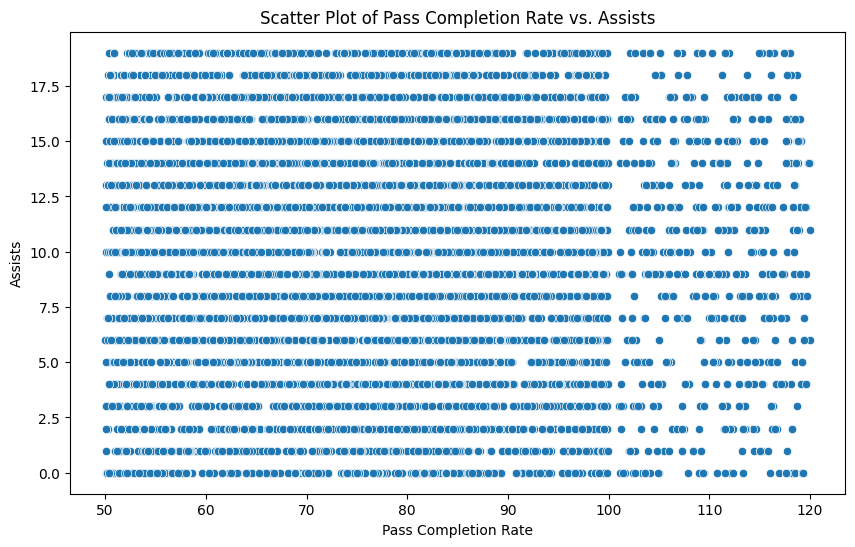

In [10]:
# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='PassCompletionRate', y='Assists')
plt.title('Scatter Plot of Pass Completion Rate vs. Assists')
plt.xlabel('Pass Completion Rate')
plt.ylabel('Assists')
plt.show()

## Outlier detection using DBSCAN

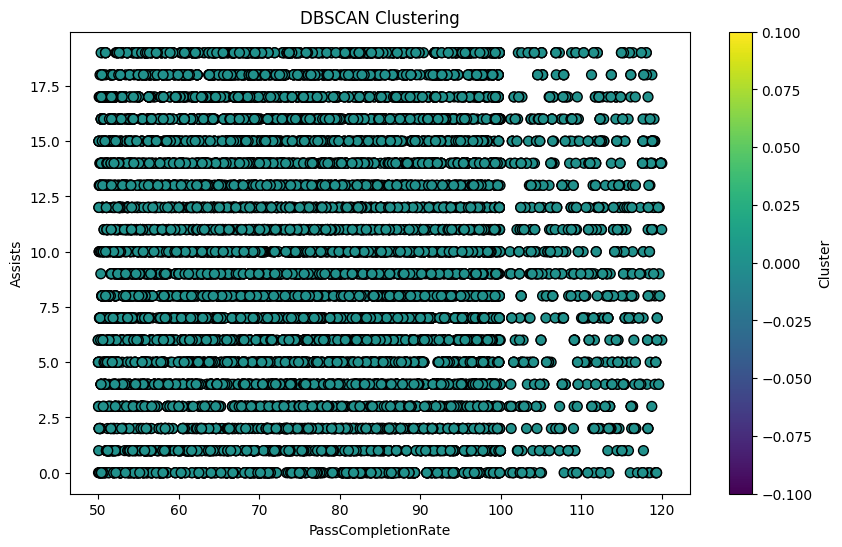

In [11]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

# Scale the data
X = StandardScaler().fit_transform(df[['PassCompletionRate', 'Assists']])

# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=30)
dbscan.fit(X)

# Extract cluster labels
labels = dbscan.labels_

# Plot clusters
plt.figure(figsize=(10, 6))
plt.scatter(df['PassCompletionRate'], df['Assists'], c=labels, cmap='viridis', marker='o', edgecolor='k', s=50)
plt.title("DBSCAN Clustering")
plt.xlabel("PassCompletionRate")
plt.ylabel("Assists")
plt.colorbar(label='Cluster')
plt.show()


## Detect outliers using DBSCAN

In [12]:
import pandas as pd
from sklearn.cluster import DBSCAN

# Assuming df is your DataFrame containing the 'PassCompletionRate' and 'Assists' columns
pass_completion_rate = df['PassCompletionRate']
assists = df['Assists']

# Reshape the data for DBSCAN
X = df[['PassCompletionRate', 'Assists']]

# DBSCAN outlier detection
dbscan = DBSCAN(eps=0.5, min_samples=5)
df['dbscan_outlier'] = dbscan.fit_predict(X)

# Filter out the outliers
df_no_outliers = df[df['dbscan_outlier'] != -1]  # Exclude outliers (label -1) from the DataFrame

# Print summary statistics and outliers
print("Summary Statistics:")
print("Number of Outliers for PassCompletionRate:", len(df[df['dbscan_outlier'] == -1]))
print("Number of Outliers for Assists:", len(df[df['dbscan_outlier'] == -1]))
print("\nOutliers for PassCompletionRate:")
print(df[df['dbscan_outlier'] == -1]['PassCompletionRate'])
print("\nOutliers for Assists:")
print(df[df['dbscan_outlier'] == -1]['Assists'])


Summary Statistics:
Number of Outliers for PassCompletionRate: 555
Number of Outliers for Assists: 555

Outliers for PassCompletionRate:
32       117.124571
34       107.806800
59       103.190260
66       103.194948
71       115.115196
            ...    
16489    111.496792
16568    104.800254
16580    114.973453
16584    111.749138
16589    110.950907
Name: PassCompletionRate, Length: 555, dtype: float64

Outliers for Assists:
32        7
34       18
59        2
66       14
71       16
         ..
16489     7
16568     1
16580    19
16584    13
16589     6
Name: Assists, Length: 555, dtype: int64


## Statistical method to detect outliers using IQR apart from DBSCAN

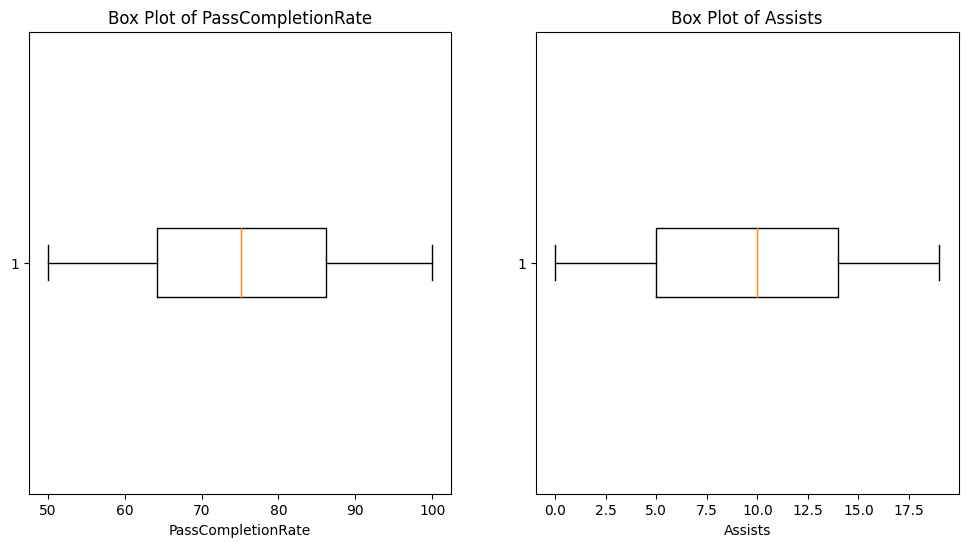

PassCompletionRate Summary Statistics:
Mean: 75.16263815883536
Median: 75.16263815883538
Standard Deviation: 13.665372627548992
Q1 (25th percentile): 64.26925956606841
Q3 (75th percentile): 86.17532165177693
IQR: 21.906062085708513
Lower Threshold for Outliers: 31.410166437505644
Upper Threshold for Outliers: 119.03441478033969

Number of Outliers for PassCompletionRate: 0
Outliers for PassCompletionRate: Series([], Name: PassCompletionRate, dtype: float64)

Assists Summary Statistics:
Mean: 9.550878037045946
Median: 10.0
Standard Deviation: 5.3462757291003875
Q1 (25th percentile): 5.0
Q3 (75th percentile): 14.0
IQR: 9.0
Lower Threshold for Outliers: -8.5
Upper Threshold for Outliers: 27.5

Number of Outliers for Assists: 0
Outliers for Assists: Series([], Name: Assists, dtype: int64)


In [72]:
# import pandas as pd
# import matplotlib.pyplot as plt

# # Assuming df is your DataFrame containing the 'PassCompletionRate' and 'Assists' columns
# pass_completion_rate = df['PassCompletionRate']
# assists = df['Assists']

# # Calculate summary statistics for PassCompletionRate
# mean_pass_completion_rate = pass_completion_rate.mean()
# median_pass_completion_rate = pass_completion_rate.median()
# std_dev_pass_completion_rate = pass_completion_rate.std()
# Q1_pass_completion_rate = pass_completion_rate.quantile(0.25)
# Q3_pass_completion_rate = pass_completion_rate.quantile(0.75)

# # Calculate interquartile range (IQR) for PassCompletionRate
# IQR_pass_completion_rate = Q3_pass_completion_rate - Q1_pass_completion_rate

# # Define the threshold for outliers for PassCompletionRate
# lower_threshold_pass_completion_rate = Q1_pass_completion_rate - 1.5 * IQR_pass_completion_rate
# upper_threshold_pass_completion_rate = Q3_pass_completion_rate + 1.5 * IQR_pass_completion_rate

# # Identify outliers for PassCompletionRate
# outliers_pass_completion_rate = pass_completion_rate[(pass_completion_rate < lower_threshold_pass_completion_rate) | (pass_completion_rate > upper_threshold_pass_completion_rate)]

# # Calculate summary statistics for Assists
# mean_assists = assists.mean()
# median_assists = assists.median()
# std_dev_assists = assists.std()
# Q1_assists = assists.quantile(0.25)
# Q3_assists = assists.quantile(0.75)

# # Calculate interquartile range (IQR) for Assists
# IQR_assists = Q3_assists - Q1_assists

# # Define the threshold for outliers for Assists
# lower_threshold_assists = Q1_assists - 1.5 * IQR_assists
# upper_threshold_assists = Q3_assists + 1.5 * IQR_assists

# # Identify outliers for Assists
# outliers_assists = assists[(assists < lower_threshold_assists) | (assists > upper_threshold_assists)]

# # Plot box plots for PassCompletionRate and Assists
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.boxplot(pass_completion_rate, vert=False)
# plt.title('Box Plot of PassCompletionRate')
# plt.xlabel('PassCompletionRate')

# plt.subplot(1, 2, 2)
# plt.boxplot(assists, vert=False)
# plt.title('Box Plot of Assists')
# plt.xlabel('Assists')

# plt.show()

# # Print summary statistics and outliers for PassCompletionRate
# print("PassCompletionRate Summary Statistics:")
# print("Mean:", mean_pass_completion_rate)
# print("Median:", median_pass_completion_rate)
# print("Standard Deviation:", std_dev_pass_completion_rate)
# print("Q1 (25th percentile):", Q1_pass_completion_rate)
# print("Q3 (75th percentile):", Q3_pass_completion_rate)
# print("IQR:", IQR_pass_completion_rate)
# print("Lower Threshold for Outliers:", lower_threshold_pass_completion_rate)
# print("Upper Threshold for Outliers:", upper_threshold_pass_completion_rate)
# print("\nNumber of Outliers for PassCompletionRate:", len(outliers_pass_completion_rate))
# print("Outliers for PassCompletionRate:", outliers_pass_completion_rate)

# # Print summary statistics and outliers for Assists
# print("\nAssists Summary Statistics:")
# print("Mean:", mean_assists)
# print("Median:", median_assists)
# print("Standard Deviation:", std_dev_assists)
# print("Q1 (25th percentile):", Q1_assists)
# print("Q3 (75th percentile):", Q3_assists)
# print("IQR:", IQR_assists)
# print("Lower Threshold for Outliers:", lower_threshold_assists)
# print("Upper Threshold for Outliers:", upper_threshold_assists)
# print("\nNumber of Outliers for Assists:", len(outliers_assists))
# print("Outliers for Assists:", outliers_assists)


## Regression analysis and cross validation

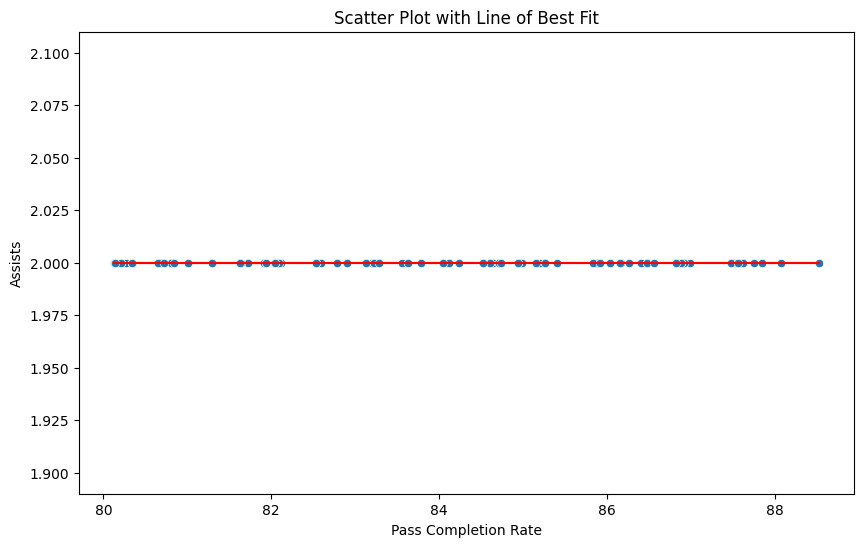

Mean Squared Error: 0.0
R-squared: 1.0
Cross-validated Mean Squared Error: -0.0
Cross-validated R-squared: 1.0


In [74]:

# Plotting the line of best fit
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_no_outliers, x='PassCompletionRate', y='Assists')
plt.title('Scatter Plot with Line of Best Fit')
plt.xlabel('Pass Completion Rate')
plt.ylabel('Assists')

# Linear Regression
X = df_no_outliers[['PassCompletionRate']]
y = df_no_outliers['Assists']
reg = LinearRegression().fit(X, y)
y_pred = reg.predict(X)

# Plotting the line of best fit
plt.plot(df_no_outliers['PassCompletionRate'], y_pred, color='red')
plt.show()

# Regression analysis
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Cross-validation
cross_val_scores = cross_val_score(reg, X, y, cv=5, scoring='neg_mean_squared_error')
cross_val_mse = -np.mean(cross_val_scores)
cross_val_r2 = np.mean(cross_val_score(reg, X, y, cv=5, scoring='r2'))

print(f'Cross-validated Mean Squared Error: {cross_val_mse}')
print(f'Cross-validated R-squared: {cross_val_r2}')
